## Dependencies

In [3]:
import pandas as pd 
from CreditScoringToolkit import frequency_table
from CreditScoringToolkit import DiscreteNormalizer
from CreditScoringToolkit import WoeEncoder
from CreditScoringToolkit import WoeContinuousFeatureSelector
from CreditScoringToolkit import WoeDiscreteFeatureSelector
from CreditScoringToolkit import CreditScoring
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._discretization")

## Reading example data

In [2]:
df = pd.read_parquet('../data/churn.parquet')

In [15]:
train,valid = train_test_split(df,test_size=0.3,random_state=2401)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((1960, 14), (841, 14))

## Defining feature type

In [16]:
#  Assign features lists by type, file contains "C_" prefix for continuous, and "D_" for discrete.
vard = [v for v in train.columns if v[:2]=='C_']
varc = [v for v in train.columns if v[:2]=='V_']

## Normalize Discrete Features

In [17]:
#  In this example, we aggregate categories with less than 10% of relative frequency
#  into a new category called 'SMALL CATEGORIES', if new created category don't reach
#  given relative frequency threshold (10%) then the most frequent category is imputed.
#  All missing values are treatead as the separate category MISSING

dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='SMALL CATEGORIES')
dn.fit(train[vard])
Xt = dn.transform(train[vard])
frequency_table(Xt,vard)

**** Frequency Table for C_IP ****

      Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
C_IP                                                          
No          1960         1.0             1960              1.0




**** Frequency Table for C_VMP ****

       Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
C_VMP                                                          
No           1438    0.733673             1438         0.733673
Yes           522    0.266327             1960         1.000000






### Check if Normalization process didn't produce unary features

In [18]:
unary = [v for v in vard if Xt[v].nunique()==1]
unary

['C_IP']

In [19]:
vard = [v for v in vard if v not in unary]

In [20]:
#  In this example, we aggregate categories with less than 10% of relative frequency
#  into a new category called 'SMALL CATEGORIES', if new created category don't reach
#  given relative frequency threshold (10%) then the most frequent category is imputed.
#  All missing values are treatead as the separate category MISSING

dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='SMALL CATEGORIES')
dn.fit(train[vard])
Xt = dn.transform(train[vard])
frequency_table(Xt,vard)

**** Frequency Table for C_VMP ****

       Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
C_VMP                                                          
No           1438    0.733673             1438         0.733673
Yes           522    0.266327             1960         1.000000






In [23]:
pd.crosstab(train[vard[0]],train['TARGET']).to_clipboard()

## WoE Based Best Feature Selection

In [24]:
#   Now we proceed with feature selection, we have special classes for each type of feature (discrete,continuous)
#   Discrete feature selector uses the given iv_threshold to select the best features only.
#   For continuous feature selector, a variety of methods are available for selecting the best features , namely:
#    -uniform: only uses equal-width discretized bins, selects number of bins with best IV value.  
#    -quantile: only uses equal-frequency discretized bins, selects number of bins with best IV value 
#    -kmeans: only uses discretized bins created by a K-Means clustering, selects number of bins with best IV value 
#    -gaussian: only uses discretized bins created by a Gaussian Mixture, selects number of bins with best IV value
#    -dcc: stands for Discrete Competitive Combination, creates segments for all individual methods and then 
#          selects the best method and its corresponding best number of bins for each feature.
#    -dec: stands for Discrete Exhaustive Combination, creates segments for all individual methods and then 
#          selects the best number of bins for each feature including every feasible method.
#
#   One can configure IV threshold, minimun/maximum number of discretization bins, whether or not to keep only
#   strictly monotonic segments and the number of pooling threads used in order to speed computations. 


Xt = pd.concat([Xt,train[varc]],axis=1) #Merge continuous features matrix with the normalized discrete predictors Matrix

wcf = WoeContinuousFeatureSelector()
wdf = WoeDiscreteFeatureSelector()

#  Perform feature selection
wcf.fit(Xt[varc],train['TARGET'],
        max_bins=6,
        strictly_monotonic=True,
        iv_threshold=0.05,
        method='dcc',
        n_threads=20)

wdf.fit(Xt[vard],train['TARGET'],iv_threshold=0.05)

#  Create new matrix with discrete and discretized best features 
Xt = pd.concat([wdf.transform(Xt[vard]),wcf.transform(Xt[varc])],axis=1)

features = list(Xt.columns)

#  Print selection results
print("Best continuous features: ", wcf.selected_features)
print("Best discrete features: ",wdf.selected_features)
print("Best Features selected: ",features)

/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/sklearn/preprocessing

Best continuous features:  [{'feature': 'disc_V_CS_CALLS_4_uniform', 'iv': 0.6401116423746656, 'relevant': True, 'root_feature': 'V_CS_CALLS', 'nbins': '4', 'method': 'uniform', 'selected': True}, {'feature': 'disc_V_N_VM_MESS_4_kmeans', 'iv': 0.09369350639845113, 'relevant': True, 'root_feature': 'V_N_VM_MESS', 'nbins': '4', 'method': 'kmeans', 'selected': True}, {'feature': 'disc_V_T_EVE_CHG_4_kmeans', 'iv': 0.09571242986438938, 'relevant': True, 'root_feature': 'V_T_EVE_CHG', 'nbins': '4', 'method': 'kmeans', 'selected': True}, {'feature': 'disc_V_T_INT_CALLS_4_quantile', 'iv': 0.06073986081945186, 'relevant': True, 'root_feature': 'V_T_INT_CALLS', 'nbins': '4', 'method': 'quantile', 'selected': True}, {'feature': 'disc_V_T_INT_CHG_4_uniform', 'iv': 0.10062409432074881, 'relevant': True, 'root_feature': 'V_T_INT_CHG', 'nbins': '4', 'method': 'uniform', 'selected': True}]
Best discrete features:  {'C_VMP': 0.0893795081566936}
Best Features selected:  ['C_VMP', 'disc_V_CS_CALLS_4_unif

## WoE Transformation 

In [25]:
#  Weight of Evidence Transformation
we = WoeEncoder()
we.fit(Xt[features],train['TARGET'])
Xwt = we.transform(Xt[features])
Xwt.head()

/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:550: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].replace(woe_map)


,C_VMP,disc_V_CS_CALLS_4_uniform,disc_V_N_VM_MESS_4_kmeans,disc_V_T_EVE_CHG_4_kmeans,disc_V_T_INT_CALLS_4_quantile,disc_V_T_INT_CHG_4_uniform
0,0.570854,0.348149,0.542598,-0.515603,0.397620,0.202053
1,-0.157741,0.348149,-0.156113,0.248074,0.110549,0.202053
2,0.570854,0.309587,0.456695,0.020954,-0.260364,0.202053
3,0.570854,0.309587,0.542598,0.340572,0.397620,0.138830
4,0.570854,0.309587,0.905150,-0.515603,0.156503,-0.758604


## Logistic Regression Parameter Learning

In [26]:
lr = LogisticRegression()
lr.fit(Xwt,train['TARGET'])
print("AUC for training: ",roc_auc_score(y_score=lr.predict_proba(Xwt)[:,1],y_true=train['TARGET']))

AUC for training:  0.7771838334199772


## Scoring

In [27]:
#  In order to perform the scoring transformation, we need the WoE encoded data, 
#  the WoeEncoder fitted object and the logistic regression fitter object 
#  to produce a nice formatted scorecard
cs = CreditScoring()
cs.fit(Xwt,we,lr)
cs.scorecard

points
feature                       attribute               
C_VMP                         No                    56
                              Yes                   62
disc_V_CS_CALLS_4_uniform     (-inf, 1.5]           67
                              (1.5, 3.0]            66
                              (3.0, 4.5]             4
                              (4.5, inf]           -15
disc_V_N_VM_MESS_4_kmeans     (-inf, 9.668]         53
                              (23.864, 32.613]      67
                              (32.613, inf]         69
                              (9.668, 23.864]       77
disc_V_T_EVE_CHG_4_kmeans     (-inf, 12.855]        69
                              (12.855, 16.679]      66
                              (16.679, 20.693]      58
                              (20.693, inf]         39
disc_V_T_INT_CALLS_4_quantile (-inf, 3.0]           50
                              (3.0, 4.0]            60
                              (4.0, 6.0]            61
                              (6.0, inf]            67
disc_V_T_INT_CHG_4_uniform    (-inf, 1.795]         63
                              (1.795, 2.7]          61
                              (2.7, 3.605]          60
                              (3.605, inf]          35

## Validation

### Model Generalization

In [28]:
#  Applying all transformations to the validation data is now easy and straightforward
#  we can compute AUC to check model overfitting
Xv = pd.concat([wdf.transform(dn.transform(valid[vard])),wcf.transform(valid[varc])],axis=1)
Xwv = we.transform(Xv)
print("AUC for validation: ",roc_auc_score(y_score=lr.predict_proba(Xwv)[:,1],y_true=valid['TARGET']))

AUC for validation:  0.7235711781206171


/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:550: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].replace(woe_map)


### Scoring Distributions

/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:920: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].replace(points_map)
/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:920: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].replace(points_map)


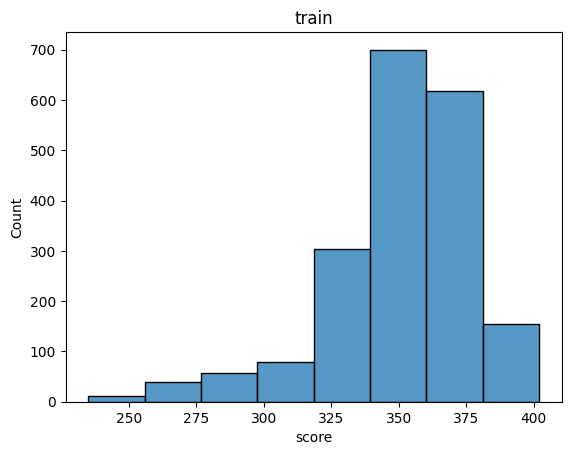

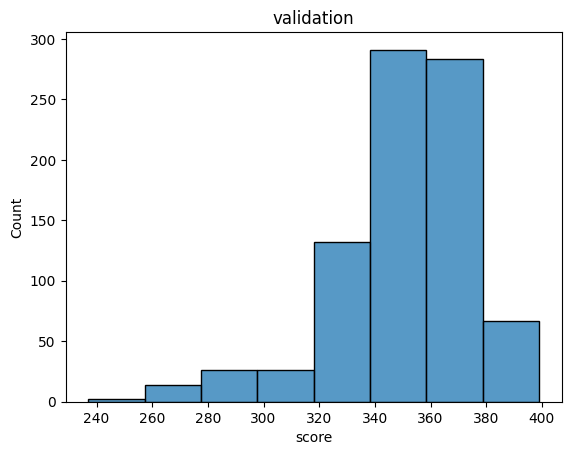

In [29]:
#  We can check the score transformation distributions for training and validation
score = pd.concat([pd.concat([cs.transform(we.inverse_transform(Xwv))[['score']].assign(sample='validation'),valid['TARGET']],axis=1),
pd.concat([cs.transform(we.inverse_transform(Xwt))[['score']].assign(sample='train'),train['TARGET']],axis=1)
                  ],ignore_index=True)

for s,d in score.groupby('sample'):
    plt.figure()
    plt.title(s)
    sns.histplot(d['score'],legend=True,fill=True,bins=8)

### Event rates

<Figure size 640x480 with 0 Axes>

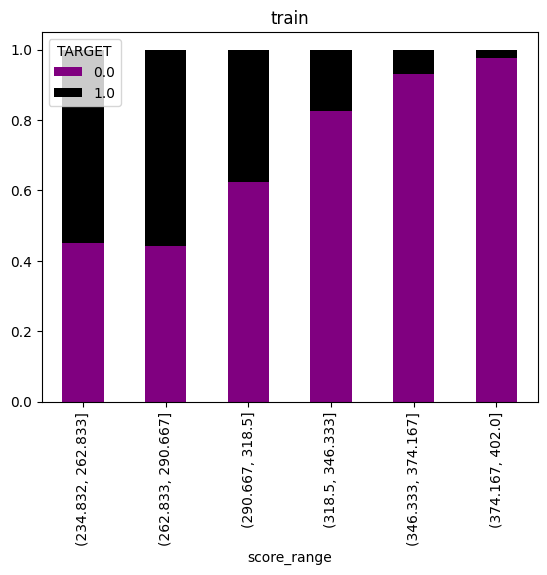

<Figure size 640x480 with 0 Axes>

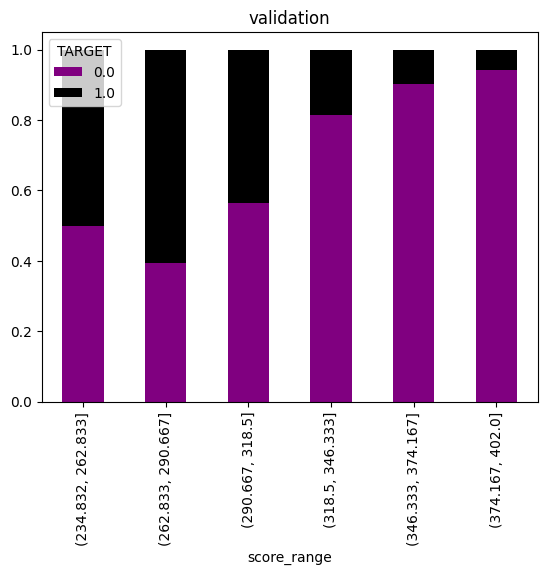

In [30]:
#   We can observe that, the greater the score, the lower the probability of being a 
#   bad customer (label=1) for both samples. Now all complexity is absorbed   
score['score_range'] = pd.cut(score['score'],bins=6,include_lowest=True).astype(str)
for s,d in score.groupby('sample'):
    aux = d.pivot_table(index='TARGET',
                        columns='score_range',
                        values='score',
                        aggfunc='count',
                        fill_value=0)
    aux/=aux.sum()
    aux = aux.T
    plt.figure()
    ax = aux.plot(kind='bar',stacked=True,color=['purple','black'])
    plt.title(s)

/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/Documents/anahuac/supreme-chainsaw/.venv/lib/python3.13/site-packages/sklearn/preprocessing

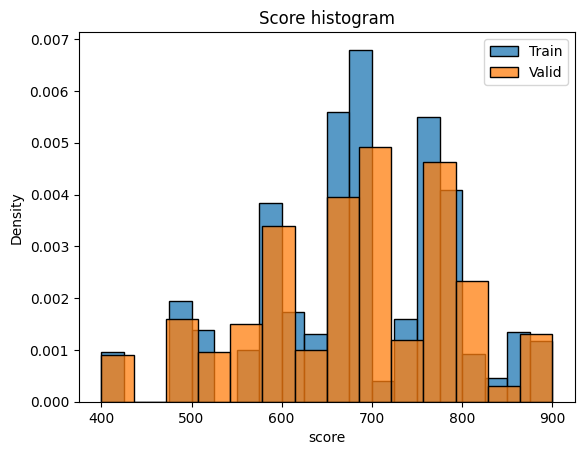

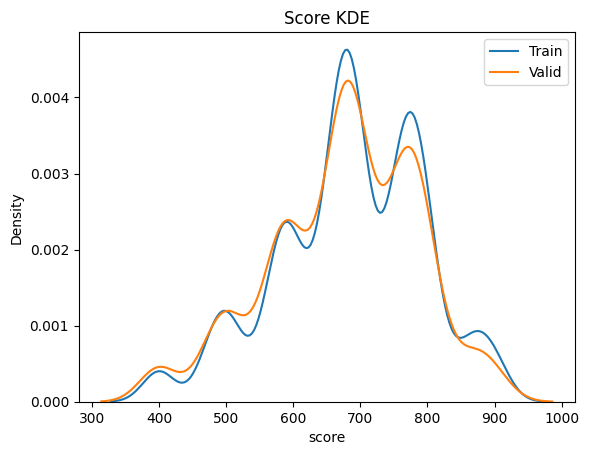

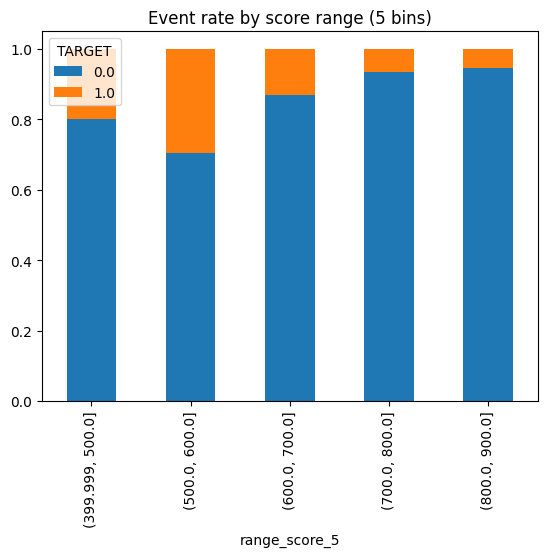

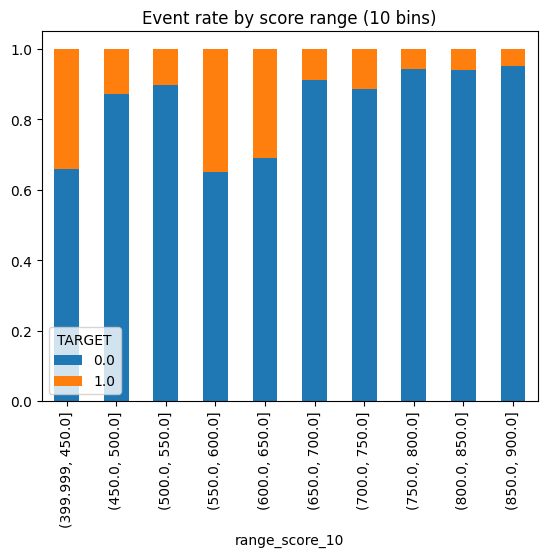

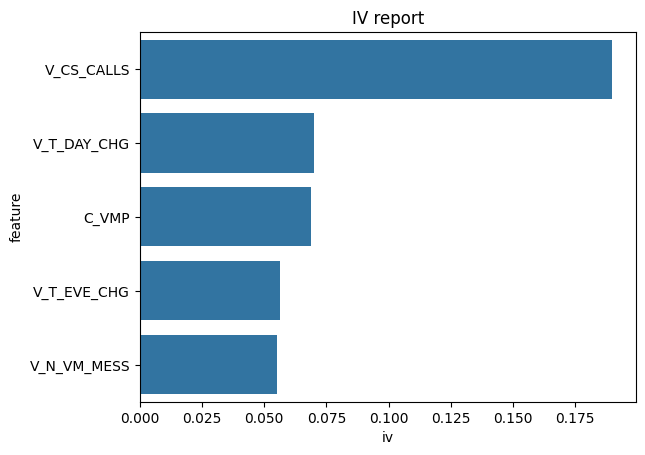

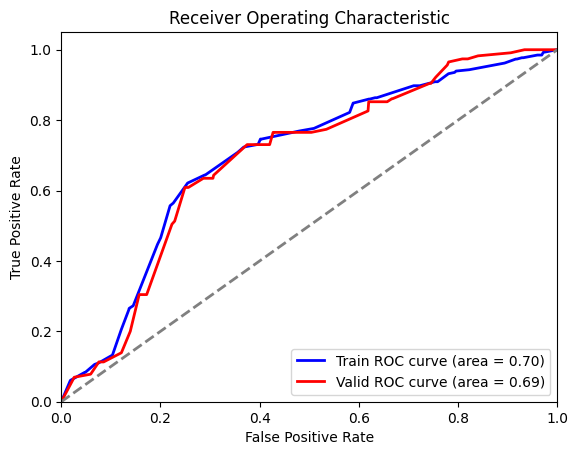

In [31]:
# If you prefer, use AutoCreditScoring class to perform all the steps in a single call with additional features
# like outlier detection and treatment, feature selection, reporting and more.
from CreditScoringToolkit import AutoCreditScoring

data = pd.concat([train,valid],axis=0)
kwargs = {'iv_feature_threshold':0.05,'max_discretization_bins':4,'strictly_monotonic':True}
acs = AutoCreditScoring(data,'TARGET',varc,vard)
acs.fit(**kwargs)

# You can also save the reports to a folder in PNG format
acs.save_reports('reports')

In [34]:
acs.credit_scoring.scorecard.to_clipboard()